<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [70]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import CIFAR10 as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [72]:
batch_size = 256
epochs = 20
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [73]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [74]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [75]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            # nn.LazyLinear(100),
            # nn.ReLU(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [76]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [77]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [78]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [79]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [80]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Files already downloaded and verified
Epoch	1	Acc:  0.3150, Loss:  0.0076
Epoch	2	Acc:  0.3652, Loss:  0.0071
Epoch	3	Acc:  0.3744, Loss:  0.0070
Epoch	4	Acc:  0.3780, Loss:  0.0070
Epoch	5	Acc:  0.3915, Loss:  0.0069
Epoch	6	Acc:  0.3916, Loss:  0.0069
Epoch	7	Acc:  0.3986, Loss:  0.0068
Epoch	8	Acc:  0.3970, Loss:  0.0068
Epoch	9	Acc:  0.3994, Loss:  0.0068
Epoch	10	Acc:  0.4038, Loss:  0.0068
Epoch	11	Acc:  0.4037, Loss:  0.0068
Epoch	12	Acc:  0.4095, Loss:  0.0067
Epoch	13	Acc:  0.4093, Loss:  0.0067
Epoch	14	Acc:  0.4087, Loss:  0.0067
Epoch	15	Acc:  0.4087, Loss:  0.0067
Epoch	16	Acc:  0.4103, Loss:  0.0067
Epoch	17	Acc:  0.4142, Loss:  0.0067
Epoch	18	Acc:  0.4145, Loss:  0.0067
Epoch	19	Acc:  0.4113, Loss:  0.0067
Epoch	20	Acc:  0.4191, Loss:  0.0066
Task 0 Acc:  0.3872, Loss:  0.0070
Task 1 Acc:  0.2276, Loss:  0.0090

Task 1 Start!
Files already downloaded and verified
Epoch	1	Acc:  0.2506, Loss:  0.0087
Epoch	2	Acc:  0.2522, Loss:  0.0087
Epoch	3	Acc:  0.2512, 

 - Task 0

Accuracy 0.3675
Classification Report
              precision    recall  f1-score   support

    airplane       0.48      0.39      0.43      1000
  automobile       0.52      0.38      0.44      1000
        bird       0.41      0.09      0.15      1000
         cat       0.25      0.38      0.30      1000
        deer       0.41      0.27      0.32      1000
         dog       0.31      0.35      0.33      1000
        frog       0.56      0.26      0.35      1000
       horse       0.32      0.58      0.41      1000
        ship       0.54      0.30      0.39      1000
       truck       0.32      0.68      0.44      1000

    accuracy                           0.37     10000
   macro avg       0.41      0.37      0.36     10000
weighted avg       0.41      0.37      0.36     10000



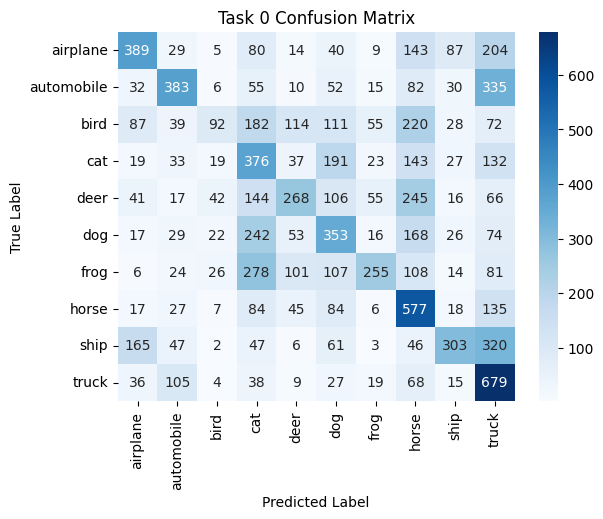

In [81]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.2528
Classification Report
              precision    recall  f1-score   support

    airplane       0.41      0.34      0.37      1000
  automobile       0.31      0.17      0.22      1000
        bird       0.11      0.03      0.05      1000
         cat       0.17      0.35      0.23      1000
        deer       0.31      0.23      0.26      1000
         dog       0.19      0.28      0.23      1000
        frog       0.42      0.24      0.31      1000
       horse       0.15      0.20      0.17      1000
        ship       0.42      0.44      0.43      1000
       truck       0.23      0.23      0.23      1000

    accuracy                           0.25     10000
   macro avg       0.27      0.25      0.25     10000
weighted avg       0.27      0.25      0.25     10000



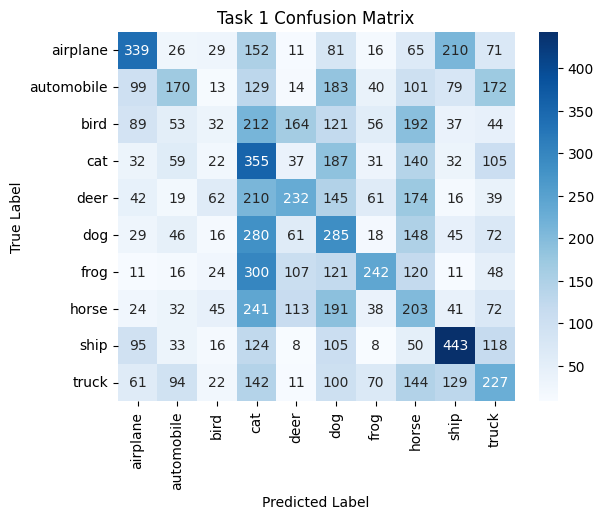

In [82]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 3072])
Max fisher is 0.94477 and it's parameter diff is 0.00007
Min Parameter diff is 0.00113 and it's fisher is 0.27001
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

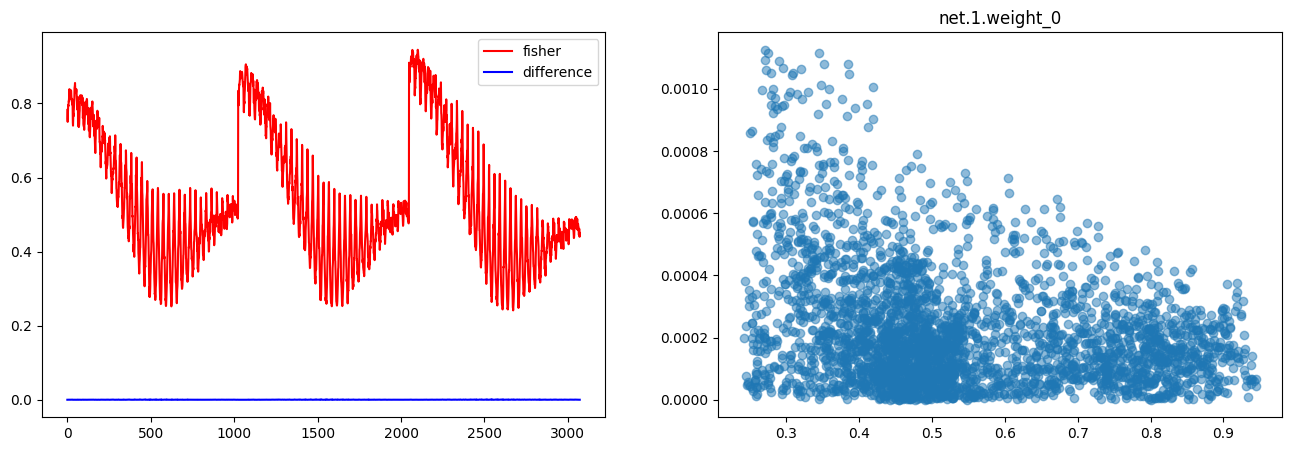

Max fisher is 0.38431 and it's parameter diff is 0.00033
Min Parameter diff is 0.00808 and it's fisher is 0.05421
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

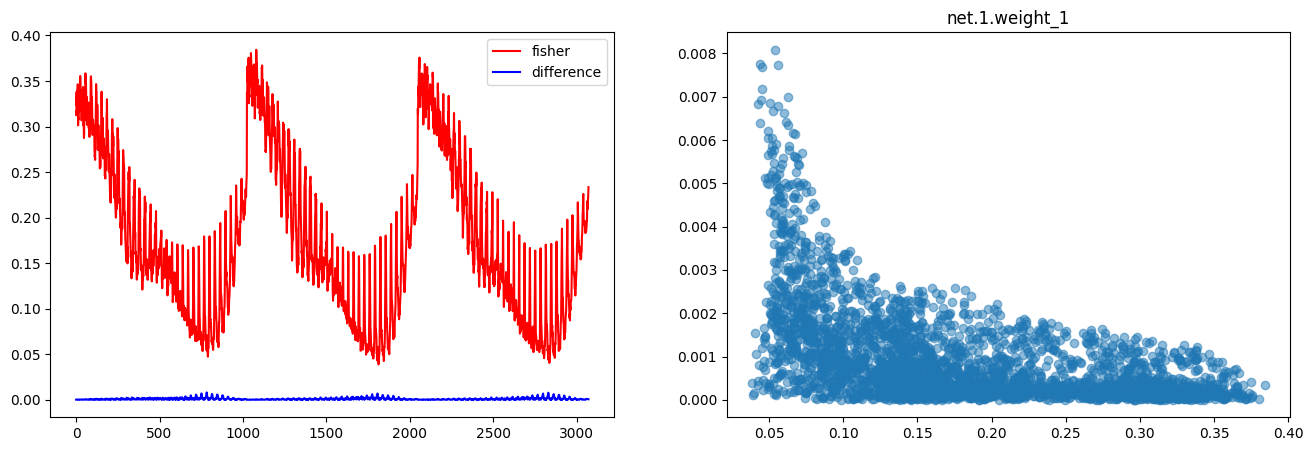

Max fisher is 1.34083 and it's parameter diff is 0.00014
Min Parameter diff is 0.00080 and it's fisher is 0.83827
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

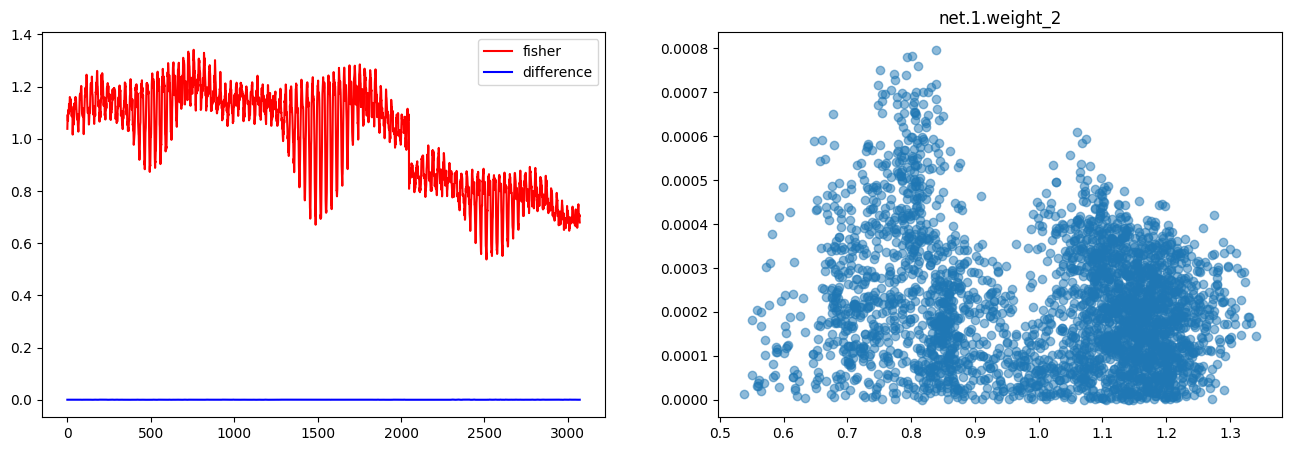

Max fisher is 0.52023 and it's parameter diff is 0.00043
Min Parameter diff is 0.00135 and it's fisher is 0.20922
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

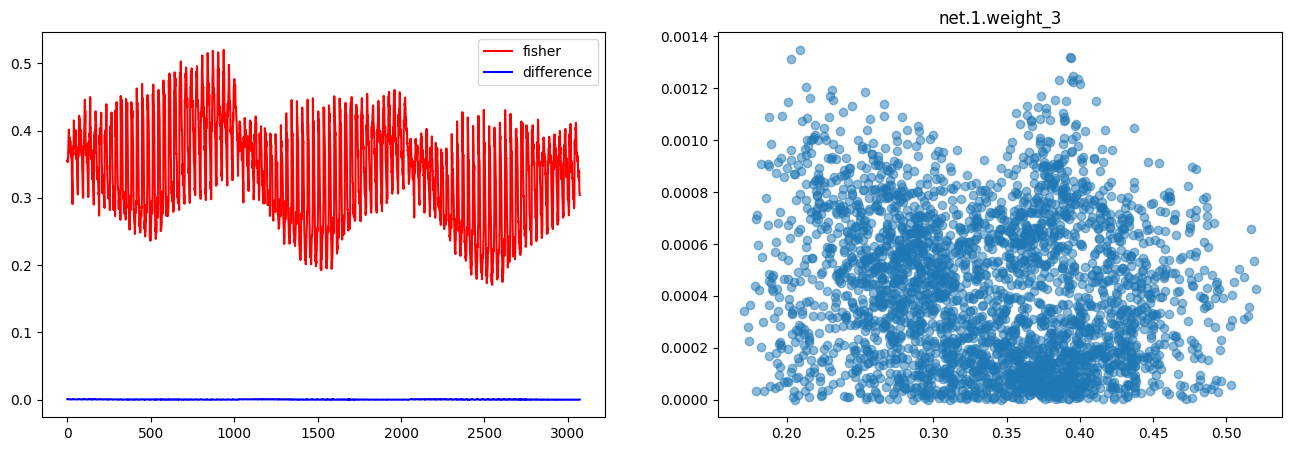

Max fisher is 0.43843 and it's parameter diff is 0.00005
Min Parameter diff is 0.00160 and it's fisher is 0.22249
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

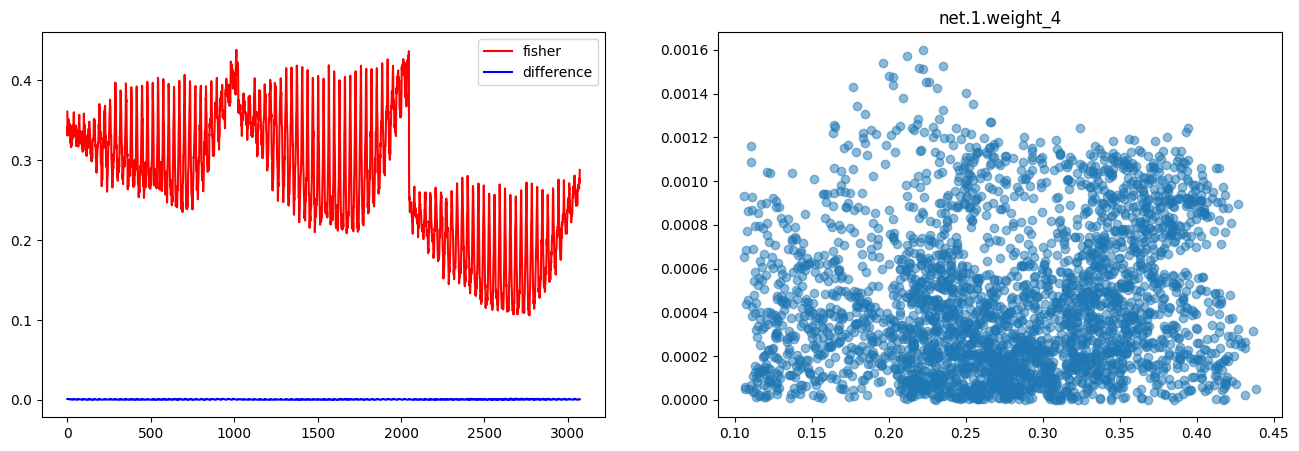

Max fisher is 9.22125 and it's parameter diff is 0.00017
Min Parameter diff is 0.00040 and it's fisher is 5.23435
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

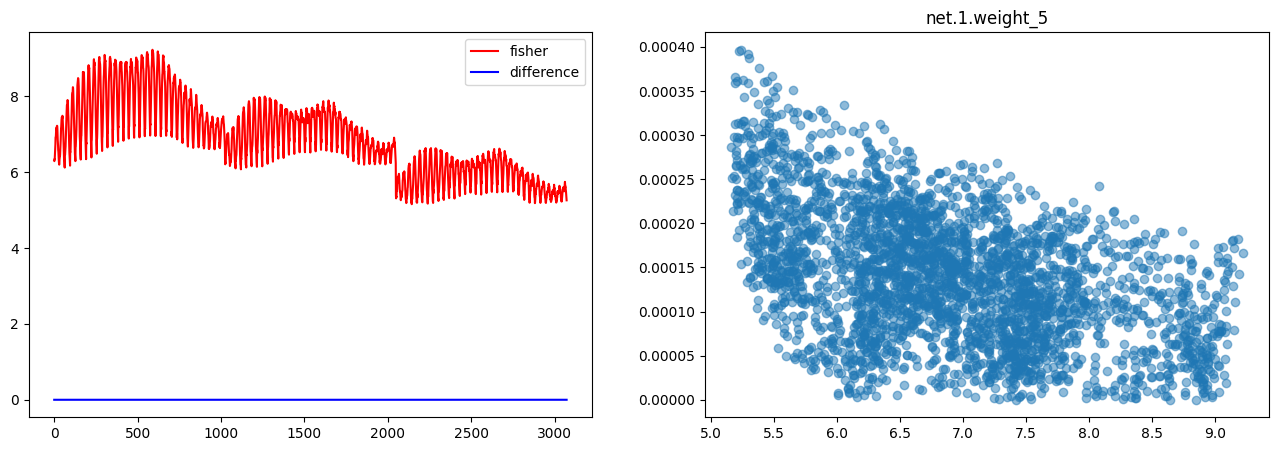

Max fisher is 5.33824 and it's parameter diff is 0.00001
Min Parameter diff is 0.00041 and it's fisher is 2.44443
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

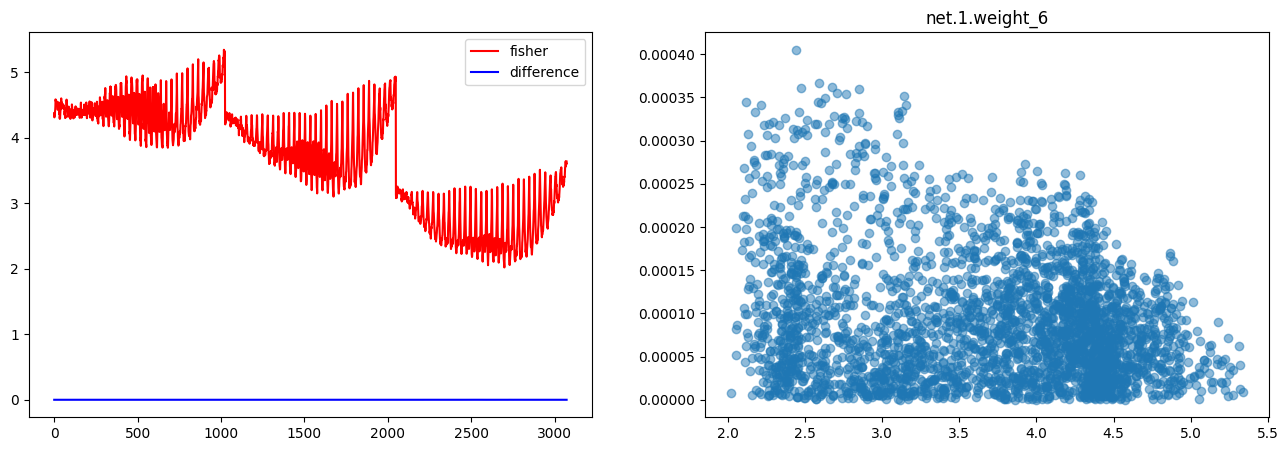

Max fisher is 4.78317 and it's parameter diff is 0.00026
Min Parameter diff is 0.00052 and it's fisher is 2.47461
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

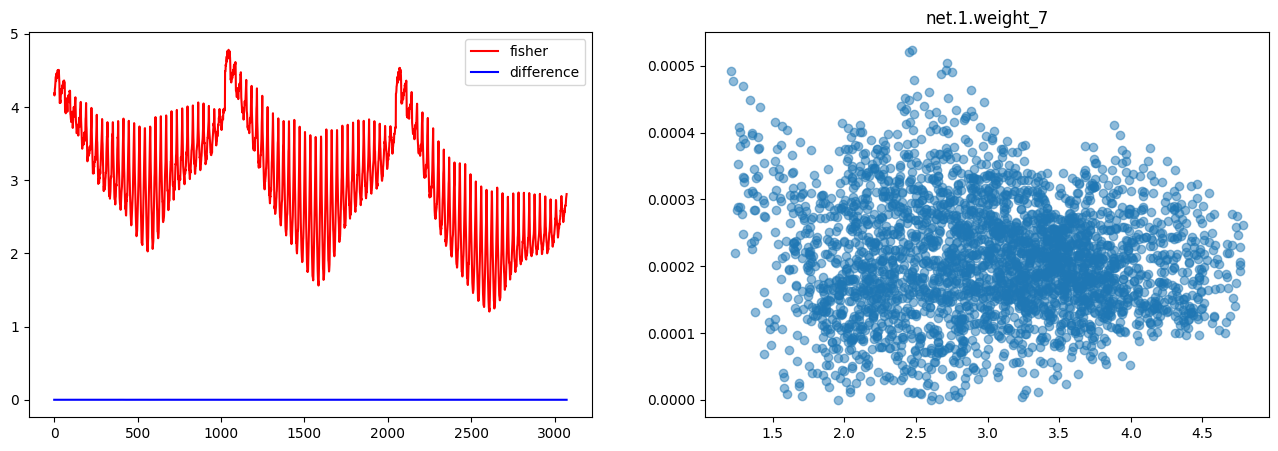

Max fisher is 0.09284 and it's parameter diff is 0.00010
Min Parameter diff is 0.02476 and it's fisher is 0.00183
fisher > parameter diff: 2878
fisher <= parameter diff: 194


<Figure size 640x480 with 0 Axes>

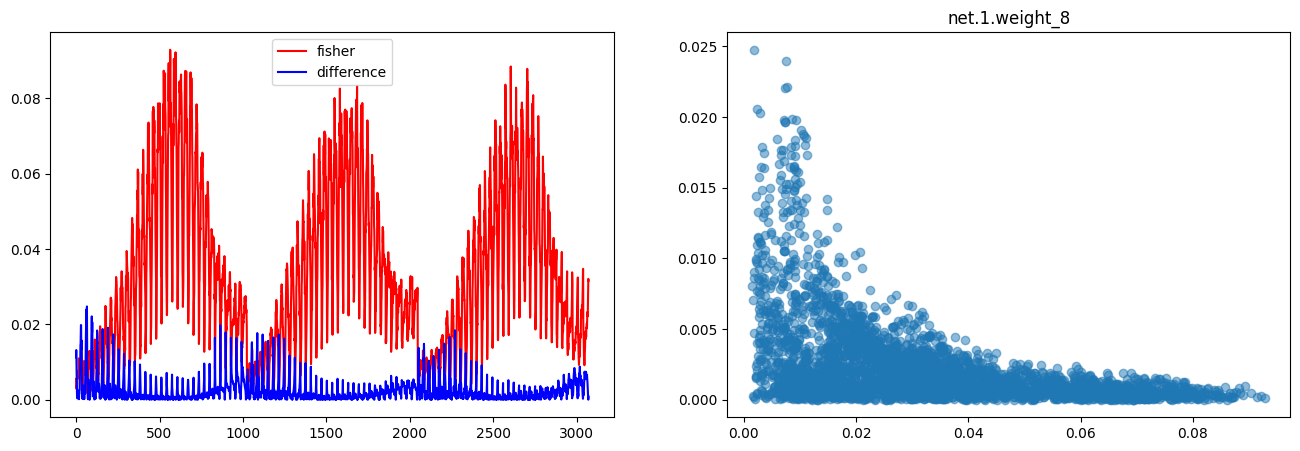

Max fisher is 1.51231 and it's parameter diff is 0.00014
Min Parameter diff is 0.00322 and it's fisher is 0.37950
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

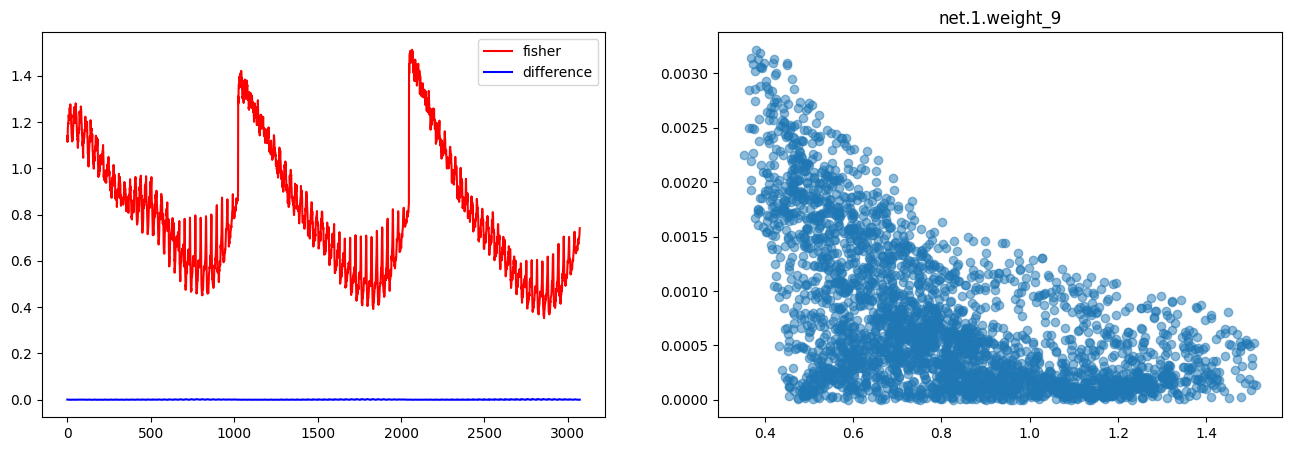


net.1.bias
torch.Size([10])
Max fisher is 29.45334 and it's parameter diff is 0.00001
Min Parameter diff is 0.03012 and it's fisher is 0.00582
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

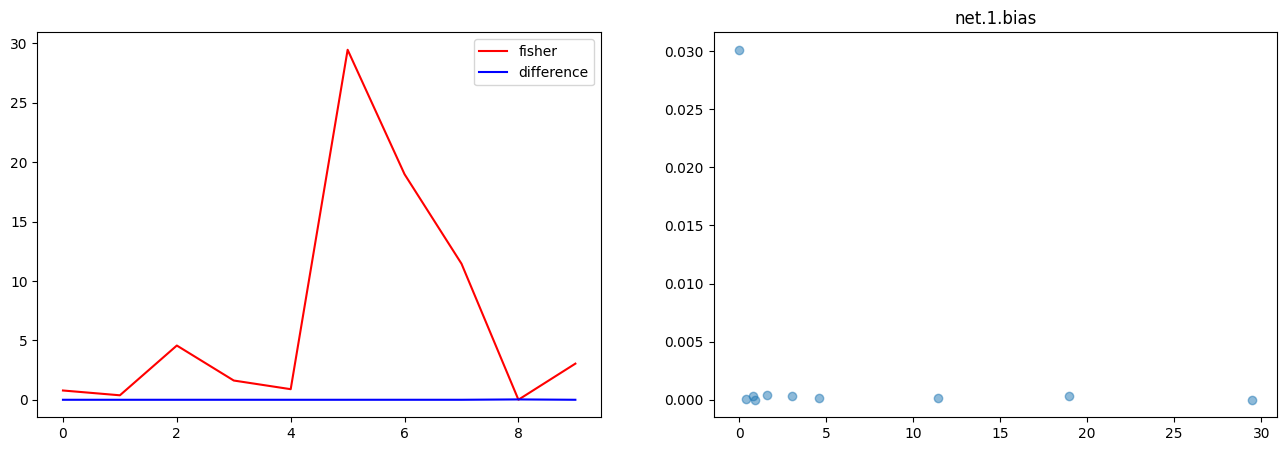

In [83]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [84]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_08_29_52
